In [280]:
%matplotlib inline
import pandas as pd
import unicodedata

import numpy as np
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct

In [281]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import strip_accents_ascii

import re
import datetime
import matplotlib.pyplot as plt

from IPython.display import display

from tqdm.autonotebook import tqdm, trange

tqdm.pandas()



# Functions

In [282]:
def log(*args):
    print("["+str(datetime.datetime.now().time())+"] ", end="")
    print(*args)

In [283]:
def clean_column(col, remove_digits=True):
    col = col.str.upper()
    col = col.apply(strip_accents_ascii)
    col = col.str.replace(r'[\.\'-/]', r' ')
    if remove_digits:
        col = col.str.replace(r'[^A-Z ]', r'')
    else:
        col = col.str.replace(r'[^A-Z0-9 ]', r'')
    col = col.str.strip()
    col = col.str.replace(r' [ ]+', r' ')
    return col

def ngrams(string, n=3):
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]


In [285]:
# https://bergvca.github.io/2017/10/14/super-fast-string-matching.html
def awesome_cossim_top(A, B, ntop, lower_bound=0):
    # force A and B as a CSR matrix.
    # If they have already been CSR, there is no overhead
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape
 
    idx_dtype = np.int32
 
    nnz_max = M*ntop
 
    indptr = np.zeros(M+1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)

    ct.sparse_dot_topn(
        M, N, np.asarray(A.indptr, dtype=idx_dtype),
        np.asarray(A.indices, dtype=idx_dtype),
        A.data,
        np.asarray(B.indptr, dtype=idx_dtype),
        np.asarray(B.indices, dtype=idx_dtype),
        B.data,
        ntop,
        lower_bound,
        indptr, indices, data)

    return csr_matrix((data,indices,indptr),shape=(M,N))

In [286]:
def get_matches_df(sparse_matrix, name_vector, field="cleansed"):
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    nr_matches = sparsecols.size
    
    left_side  = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    
    left_side_idx  = np.empty([nr_matches], dtype=int)
    right_side_idx = np.empty([nr_matches], dtype=int)

    left_side_count  = np.empty([nr_matches], dtype=int)
    right_side_count = np.empty([nr_matches], dtype=int)

    similarity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] =  name_vector.loc[sparsecols[index]][field]
        right_side[index] = name_vector.loc[sparserows[index]][field]

        left_side_idx[index] =  sparsecols[index]
        right_side_idx[index] = sparserows[index]

        left_side_count[index] =  name_vector.loc[sparsecols[index]]["count"]
        right_side_count[index] = name_vector.loc[sparserows[index]]["count"]


        similarity[index] = sparse_matrix.data[index]
    
    matches = pd.DataFrame({  'left':        left_side,
                              'right':       right_side,
                              'left_idx':    left_side_idx,
                              'right_idx':   right_side_idx,
                              'left_count':  left_side_count,
                              'right_count': right_side_count,
                              'left_count_box':   find_box(left_side_count),
                              'right_count_box':  find_box(right_side_count),
                              'similarity': similarity}).dropna()

    
    return matches[matches.left_idx != matches.right_idx]

In [287]:
def get_matches(names, top=100, threshold=0.5, field="cleansed", monotonic=True):
    
    log("Vectorizing...")
    vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
    tf_idf_matrix = vectorizer.fit_transform(names[field])
        
    log("Run cossim...")
    matches = awesome_cossim_top(tf_idf_matrix, tf_idf_matrix.transpose(), top, threshold)

    log("Make match dataframe")
    matches = get_matches_df(matches, names, field)
    
    if monotonic:
        matches =  matches[(matches.left_count< matches.right_count) | ( (matches.left_count ==  matches.right_count) & (matches.left_idx < matches.right_idx) )] 

    return matches

In [288]:
def get_names_count(filename, col_name, sample=False):
    df = pd.read_csv(filename, usecols = [col_name])
    
    if sample:
        df = df.sample(sample)
    df_col = df[col_name].value_counts()
    df_col = df_col.reset_index(name="count")
    return df_col

In [289]:
def find_box(x, boxes=np.array([0, 1, 2, 3, 4, 5, 10, 20, 50, 100, 500, 1000])): 
    return boxes[boxes.searchsorted(x, side="right")-1]


In [371]:
def get_inclusions(df,field = "cleansed", max_length_diff=5, max_length_ratio=1.5, monotonic = True):
    
    df["str_len"]  = df[field].str.len()
    
    candidates = df[["str_len"]].reset_index()
    str_lens = candidates.str_len.unique()
    str_lens.sort()

    candidates["str_len_y"] = candidates.str_len.apply(lambda item: [x for x in str_lens if (x+2 <= item <= x+max_length_diff) and (item/x) < max_length_ratio]) 

    candidates = candidates.str_len_y.apply(pd.Series).merge(candidates, left_index=True, right_index=True).drop("str_len_y", axis=1).melt(id_vars = ["index", "str_len"], value_name="str_len_y").drop("variable", axis=1).dropna()
    candidates = candidates.merge(df[["str_len"]].reset_index(), left_on="str_len_y", right_on="str_len")
    candidates = candidates[["index_x", "index_y"]]
    
    candidates = candidates.merge(df.drop(["str_len"], axis=1).rename(columns ={f:f+"_x" for f in df.keys()}), left_on="index_x", right_index=True)
    candidates = candidates.merge(df.drop(["str_len"], axis=1).rename(columns ={f:f+"_y" for f in df.keys()}), left_on="index_y", right_index=True)
    
    if monotonic : # Only consider inclusion in more frequent words
        candidates = candidates[candidates.count_x <= candidates.count_y]

    match = [x[0]+" " in x[1] or " "+x[0] in x[1] for x in tqdm(zip(candidates[field+"_y"], candidates[field+"_x"]), total=candidates.shape[0], leave=False)]
    
    return candidates[match]

# Read data

In [291]:
col_names  = ["Street",  "Street_batch", "Street_cluster"]
filename = "Bxl_all-blog.csv"
sample = False


In [292]:
pd.read_csv(filename, usecols=col_names)

Street                 Street_batch  \
0                      Rue du Chêne                 RUE DU CHÊNE   
1                       Place Madou                  PLACE MADOU   
2            Avenue de l'Astronomie       AVENUE DE L'ASTRONOMIE   
3            Avenue de l'Astronomie       AVENUE DE L'ASTRONOMIE   
4         Boulevard du Roi AlbertII    BOULEVARD DU ROI ALBERTII   
5                Avenue Paul Hymans           AVENUE PAUL HYMANS   
6                     Rue de Trèves                RUE DE TRÈVES   
7                 Boulevard Pachéco            BOULEVARD PACHÉCO   
8        Boulevard de l'Impératrice   BOULEVARD DE L'IMPÉRATRICE   
9                Avenue du Maelbeek           AVENUE DU MAELBEEK   
10          Boulevard de Berlaimont      BOULEVARD DE BERLAIMONT   
11                Drève Sainte-Anne            DRÈVE SAINTE-ANNE   
12                    Rue de la Loi                RUE DE LA LOI   
13                     Rue Montoyer                 RUE MONTOYER   
14                    Rue de la Loi                RUE DE LA LOI   
15         Place Maurice Van Meenen     PLACE MAURICE VAN MEENEN   
16                Avenue du Silence            AVENUE DU SILENCE   
17                    Rue de France                RUE DE FRANCE   
18         Boulevard Sylvain Dupuis     BOULEVARD SYLVAIN DUPUIS   
19                    Rue de Naples                RUE DE NAPLES   
20                  Square de Meeûs              SQUARE DE MEEÛS   
21                      Rue Léopold                  RUE LÉOPOLD   
22       Place Arthur Van Gehuchten   PLACE ARTHUR VAN GEHUCHTEN   
23                 Place du Conseil             PLACE DU CONSEIL   
24              Avenue de Tervueren          AVENUE DE TERVUEREN   
25                  Rue de l'Evêque              RUE DE L'EVÊQUE   
26            Rue Capitaine Crespel        RUE CAPITAINE CRESPEL   
27         Avenue de la Toison d'Or     AVENUE DE LA TOISON D'OR   
28               Place Victor Horta           PLACE VICTOR HORTA   
29                  Place Stéphanie              PLACE STÉPHANIE   
...                             ...                          ...   
266416              Rue du Melkriek              RUE DU MELKRIEK   
266417              Rue du Melkriek              RUE DU MELKRIEK   
266418             Rue Champ du Roi             RUE CHAMP DU ROI   
266419                Avenue Louise                AVENUE LOUISE   
266420          Avenue de Tervueren          AVENUE DE TERVUEREN   
266421           Place Peter Benoit           PLACE PETER BENOIT   
266422            Rue de Birmingham            RUE DE BIRMINGHAM   
266423                  Rue Jourdan                  RUE JOURDAN   
266424         Rue des Pères Blancs         RUE DES PÈRES BLANCS   
266425              Avenue Eléonore              AVENUE ELÉONORE   
266426           Avenue des Azalées           AVENUE DES AZALÉES   
266427                Rue Léopold I                RUE LÉOPOLD I   
266428  Rue de l'Hôtel des Monnaies  RUE DE L'HÔTEL DES MONNAIES   
266429                 Rue Martin V                 RUE MARTIN V   
266430             Quai du Commerce             QUAI DU COMMERCE   
266431    Rue du Marché aux Poulets    RUE DU MARCHÉ AUX POULETS   
266432             Rue Vanderlinden             RUE VANDERLINDEN   
266433             Rue Edith Cavell             RUE EDITH CAVELL   
266434           Chaussée de Wemmel           CHAUSSÉE DE WEMMEL   
266435    Avenue Franklin Roosevelt    AVENUE FRANKLIN ROOSEVELT   
266436     Place Marcel Broodthaers     PLACE MARCEL BROODTHAERS   
266437             Rue de Jérusalem             RUE DE JÉRUSALEM   
266438          Avenue de la Chasse          AVENUE DE LA CHASSE   
266439           Avenue Daniel Boon           AVENUE DANIEL BOON   
266440               Rue de Flandre               RUE DE FLANDRE   
266441                   Rue Royale                   RUE ROYALE   
266442                    Rue Wayez                    RUE WAYEZ   
266443          A

In [293]:
names = {}
for col in col_names:
    names[col] = get_names_count(filename = filename, col_name = col, sample=sample)
    print(col)
    display(names[col])


Street


index  count
0                        Avenue Louise   6873
1                 Chaussée de Waterloo   3254
2                 Chaussée d'Alsemberg   2469
3                    Chaussée de Wavre   2099
4                  Avenue de Tervueren   1846
5                     Chaussée de Mons   1544
6                      Avenue Brugmann   1511
7                   Chaussée de Haecht   1418
8                     Chaussée de Gand   1386
9                  Chaussée de Louvain   1362
10                          Rue Royale   1192
11            Avenue Winston Churchill   1078
12                Chaussée de La Hulpe    993
13                  Chaussée de Ninove    951
14               Avenue de la Couronne    934
15               Chaussée de Charleroi    923
16            Boulevard Louis Mettewie    899
17                Avenue Charles-Quint    888
18                    Rue de la Presse    845
19              Boulevard du Souverain    827
20           Avenue Franklin Roosevelt    823
21                      Avenue Molière    788
22             Boulevard Louis Schmidt    772
23                      Avenue du Port    735
24                     Avenue des Arts    732
25               Avenue de Broqueville    723
26                           Rue Haute    700
27                Chaussée de Boondael    688
28                   Rue Vanderkindere    680
29           Boulevard Emile Bockstael    680
...                                ...    ...
6837          Avenue Louise, 271 Etage      1
6838             Rogiercentrum, 6 b442      1
6839                       22 HOUNAUTS      1
6840  Place de la Station-Gare Forest-      1
6841           Hall Gare du Midi W 215      1
6842                  rue du Jubile 44      1
6843                Avenue Louise, 75R      1
6844              Square de Meeûs  22A      1
6845          Stephensonstraat 112 Bis      1
6846  Atomiumsquare B.I.T.M. Avignon 2      1
6847          Rond-point de la Liberté      1
6848              PLACE DE L'ALBERTINE      1
6849             Brussel Plare Bara, 5      1
6850             Chaussée d'Anvers, 2A      1
6851            AVENUE DES IMMORTELLES      1
6852               Square Jules Algoet      1
6853                      AV.M.PECHEUR      1
6854            Quai des Usines, 22-23      1
6855                     54 B METTEWIE      1
6856           *Galerie Pacific, local      1
6857                             Namur      1
6858            Avenue Louise, 164 E-F      1
6859                  41 J FR LEEMANSL      1
6860            Avenue des Arts, 21Bte      1
6861                    Place du Lotus      1
6862                Rue Traveniere, 35      1
6863                    AV.LOUISE 129A      1
6864                 Fr Vekemansstraat      1
6865                  519 C DE LOUVAIN      1
6866  Avenue Louise, 108 Galerie Louis      1

[6867 rows x 2 columns]

Street_batch


index  count
0                        AVENUE LOUISE   7010
1                 CHAUSSÉE DE WATERLOO   3259
2                 CHAUSSÉE D'ALSEMBERG   2474
3                    CHAUSSÉE DE WAVRE   2104
4                  AVENUE DE TERVUEREN   1847
5                     CHAUSSÉE DE MONS   1549
6                      AVENUE BRUGMANN   1511
7                   CHAUSSÉE DE HAECHT   1426
8                     CHAUSSÉE DE GAND   1388
9                  CHAUSSÉE DE LOUVAIN   1376
10                          RUE ROYALE   1204
11            AVENUE WINSTON CHURCHILL   1079
12                CHAUSSÉE DE LA HULPE    993
13                  CHAUSSÉE DE NINOVE    951
14               AVENUE DE LA COURONNE    937
15               CHAUSSÉE DE CHARLEROI    923
16            BOULEVARD LOUIS METTEWIE    899
17                AVENUE CHARLES-QUINT    888
18                    RUE DE LA PRESSE    845
19           AVENUE FRANKLIN ROOSEVELT    829
20              BOULEVARD DU SOUVERAIN    827
21                      AVENUE MOLIÈRE    788
22             BOULEVARD LOUIS SCHMIDT    772
23                      AVENUE DU PORT    738
24                     AVENUE DES ARTS    734
25               AVENUE DE BROQUEVILLE    723
26                           RUE HAUTE    713
27                CHAUSSÉE DE BOONDAEL    694
28           BOULEVARD EMILE BOCKSTAEL    683
29                   RUE VANDERKINDERE    682
...                                ...    ...
5973  ATOMIUMSQUARE BRUSSEL TRADE MARK      1
5974                RUE DES TUBÉREUSES      1
5975                  RUE E. BOCKSTAEL      1
5976                   PLACE BLYCKAERT      1
5977                     RUE J LEJEUNE      1
5978     RUE FRANCOIS VERDONCK, 41 BTE      1
5979             AQUARIUMSQUARE ATHENE      1
5980                    WERKHUIZENKAAI      1
5981                     AVENUE P.BOLS      1
5982                   AVENUE E. DEMOT      1
5983             GALERIE DU CENTENAIRE      1
5984                INT ROGIER CENTRUM      1
5985  AVENUE DOCTEUR LEMOINE, 7 - PARC      1
5986                          E CAVELS      1
5987          IMPASSE DU VAL DES ROSES      1
5988                 CLOS DES ROSACÉES      1
5989  JARDIN MARTIN V - PLACE DU MARCH      1
5990                    PLACE I ROGIER      1
5991    RUE DU MARCHÉ AUX HERBES, S.N.      1
5992                   AVENUE E.PLASKY      1
5993              CHAUSSÉE DE BOENDAEL      1
5994          ROND POINT SCHUMAN 6 2ET      1
5995             TRADE MART E. ATHENES      1
5996                   BOLLINCKXSTRAAT      1
5997                   RUE DE LA SERRE      1
5998  ATOMIUMLAAN, F 16 FASHION GARDEN      1
5999    SQUARE SAINCTELETTE, 12, BOÎTE      1
6000                      CITÉ JOURDAN      1
6001               BOULEVARD GEN.WAHIS      1
6002                   AVENUE DES CLOS      1

[6003 rows x 2 columns]

Street_cluster


index  count
0                       AVENUE LOUISE   7010
1                CHAUSSÉE DE WATERLOO   3263
2                CHAUSSÉE D'ALSEMBERG   2506
3                   CHAUSSÉE DE WAVRE   2104
4                 AVENUE DE TERVUEREN   1852
5                    CHAUSSÉE DE MONS   1549
6                     AVENUE BRUGMANN   1513
7                  CHAUSSÉE DE HAECHT   1426
8                    CHAUSSÉE DE GAND   1390
9                 CHAUSSÉE DE LOUVAIN   1381
10                         RUE ROYALE   1204
11           AVENUE WINSTON CHURCHILL   1079
12               CHAUSSÉE DE LA HULPE    994
13                 CHAUSSÉE DE NINOVE    951
14              AVENUE DE LA COURONNE    937
15              CHAUSSÉE DE CHARLEROI    924
16               AVENUE CHARLES-QUINT    900
17           BOULEVARD LOUIS METTEWIE    899
18                   RUE DE LA PRESSE    845
19          AVENUE FRANKLIN ROOSEVELT    829
20             BOULEVARD DU SOUVERAIN    827
21                     AVENUE MOLIÈRE    805
22            BOULEVARD LOUIS SCHMIDT    772
23                     AVENUE DU PORT    738
24                    AVENUE DES ARTS    734
25              AVENUE DE BROQUEVILLE    723
26                          RUE HAUTE    713
27               CHAUSSÉE DE BOONDAEL    694
28          BOULEVARD EMILE BOCKSTAEL    683
29               BOULEVARD LÉOPOLD II    682
...                               ...    ...
5790             LIEFDADIGHEIDSSTRAAT      1
5791                     AVENUE BRUYL      1
5792            PLACE SURL.DE CHOKIER      1
5793                   RUE WIERTZ LEO      1
5794     AVENUE DE L HOPITAL FRANCAIS      1
5795                       RUSTSTRAAT      1
5796                CITY 2, RUE NEUVE      1
5797          GALLERIE CENTRE MONNAIE      1
5798                   BERCKMANSTRAAT      1
5799                  TH DE BAISIEUXS      1
5800           AVENUE POIS DE SENTEUR      1
5801                      RUE DOYENNE      1
5802                      MÉTRO TRONE      1
5803             AVENUE DES HUILERIES      1
5804               CHAUSSÉE BRUXELLES      1
5805      GRASMARKT 105 AGORA GALERIJ      1
5806           TRADE MART, BIRMINGHAM      1
5807                   RUE DE RELEGEM      1
5808      BOULEVARD BOTANIQUE PASSAGE      1
5809              ST-LAMBERTUS WINKEL      1
5810  RUE JOSEPH II, 76A HOTEL DES IN      1
5811                  CARRÉ CASSIMANS      1
5812                AVENUE STALINGRAD      1
5813                     RUE LINTHOUT      1
5814                    RUE DU BRUANT      1
5815   *POSTBUS, 34 - POST ANDERLECHT      1
5816                 RUE EMILE DE MOT      1
5817                       FREDIENSTS      1
5818             PAUL-HENRI SPAAKLAAN      1
5819                     PAUL FAUSENL      1

[5820 rows x 2 columns]

# Basic cleansing

In [358]:
cleansing_fields = ["orig", "cleansed", "cleansed_0digit","cleansed_nodigit", "cleansed_replace"]
cleansing_fields = ["cleansed", "cleansed_nodigit"]

for col in col_names:
    names[col]["orig"]             = names[col]["index"].fillna("").astype(str)
    names[col]["cleansed"]         = clean_column(names[col]["index"], remove_digits=False)
    names[col]["cleansed_0digit"]  = names[col]["cleansed"].str.replace("[0-9]", "0")
    names[col]["cleansed_nodigit"] = clean_column(names[col]["index"], remove_digits=True)
    names[col]["cleansed_replace"] = names[col]["cleansed_nodigit"].str.replace("^AV ", "AVENUE ").str.replace("^CHE* ", "CHAUSSEE ").str.replace("^B[LVB]{0,3} ", "BOULEVARD").str.replace("^R ", "RUE")
    
    names[col]["count_box"] = find_box(names[col]["count"])

In [396]:
names[col_names[0]]

index  count  \
0                        Avenue Louise   6873   
1                 Chaussée de Waterloo   3254   
2                 Chaussée d'Alsemberg   2469   
3                    Chaussée de Wavre   2099   
4                  Avenue de Tervueren   1846   
5                     Chaussée de Mons   1544   
6                      Avenue Brugmann   1511   
7                   Chaussée de Haecht   1418   
8                     Chaussée de Gand   1386   
9                  Chaussée de Louvain   1362   
10                          Rue Royale   1192   
11            Avenue Winston Churchill   1078   
12                Chaussée de La Hulpe    993   
13                  Chaussée de Ninove    951   
14               Avenue de la Couronne    934   
15               Chaussée de Charleroi    923   
16            Boulevard Louis Mettewie    899   
17                Avenue Charles-Quint    888   
18                    Rue de la Presse    845   
19              Boulevard du Souverain    827   
20           Avenue Franklin Roosevelt    823   
21                      Avenue Molière    788   
22             Boulevard Louis Schmidt    772   
23                      Avenue du Port    735   
24                     Avenue des Arts    732   
25               Avenue de Broqueville    723   
26                           Rue Haute    700   
27                Chaussée de Boondael    688   
28                   Rue Vanderkindere    680   
29           Boulevard Emile Bockstael    680   
...                                ...    ...   
6837          Avenue Louise, 271 Etage      1   
6838             Rogiercentrum, 6 b442      1   
6839                       22 HOUNAUTS      1   
6840  Place de la Station-Gare Forest-      1   
6841           Hall Gare du Midi W 215      1   
6842                  rue du Jubile 44      1   
6843                Avenue Louise, 75R      1   
6844              Square de Meeûs  22A      1   
6845          Stephensonstraat 112 Bis      1   
6846  Atomiumsquare B.I.T.M. Avignon 2      1   
6847          Rond-point de la Liberté      1   
6848              PLACE DE L'ALBERTINE      1   
6849             Brussel Plare Bara, 5      1   
6850             Chaussée d'Anvers, 2A      1   
6851            AVENUE DES IMMORTELLES      1   
6852               Square Jules Algoet      1   
6853                      AV.M.PECHEUR      1   
6854            Quai des Usines, 22-23      1   
6855                     54 B METTEWIE      1   
6856           *Galerie Pacific, local      1   
6857                             Namur      1   
6858            Avenue Louise, 164 E-F      1   
6859                  41 J FR LEEMANSL      1   
6860            Avenue des Arts, 21Bte      1   
6861                    Place du Lotus      1   
6862                Rue Traveniere, 35      1   
6863                    AV.LOUISE 129A      1   
6864                 Fr Vekemansstraat      1   
6865                  519 C DE LOUVAIN      1   
6866  Avenue Louise, 108 Galerie Louis      1   

                                  orig                         cleansed  \
0                        Avenue Louise                    AVENUE LOUISE   
1                 Chaussée de Waterloo             CHAUSSEE DE WATERLOO   
2                 Chaussée d'Alsemberg             CHAUSSEE D ALSEMBERG   
3                    Chaussée de Wavre                CHAUSSEE DE WAVRE   
4                  Avenue de Tervueren              AVENUE DE TERVUEREN   
5                     Chaussée de Mons                 CHAUSSEE DE MONS   
6                      Avenue Brugmann                  AVENUE BRUGMANN   
7                   Chaussée de Haecht               CHAUSSEE DE HAECHT   
8                     Chaussée de Gand                 CHAUSSEE DE GAND   
9                  Chaussée de Louvain              CHAUSSEE DE LOUVAIN   
10                          Rue Royale                       RUE ROYALE   
11            Avenue Winston Churchill         AVENUE WINSTON CHURCHILL   
12                C

Ratio of values/records that are equal to a value with a higher count.

Example : 

|id | value | # occ | 
|---|-------|-------|
|1  | A     | 8     |    
|2  | B     | 7     |
|3  | B     | 3     |
|4  | A     | 1     | 
|5  | A     | 1     |

Ids that are counted: 3, 4, 5.

- Ratio in values : 3 / 5 = 0.6 
- Ratio in records: 5 / 20 = 0.25

Values are cleansed the following way : 
- orig : no cleansing
- cleansed: set to uppercase, remove all accents, replaces some characters (dot, apostrophe, dash, slash) by space, remove any non alphanumeric (or space) characters, strip extra spaces
- cleansed_0digit : same as "cleansed", by replace any digit by "0"
- cleansed_nodigit : same as "cleansed", by remove any digit

As values were grouped by identical original values, "orig" ratio should be always 0


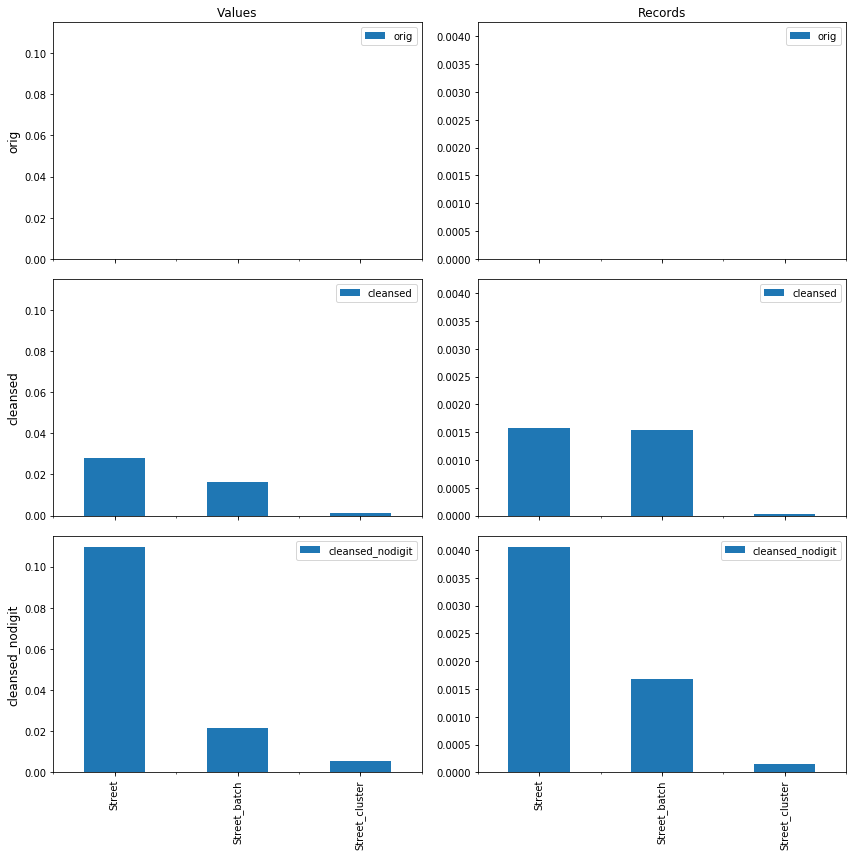

In [395]:
fig, axes = plt.subplots(len(cleansing_fields), 2,  figsize=(12,4*len(cleansing_fields)), sharey="col", sharex=True)

axes[0, 1].set_title("Records")
axes[0, 0].set_title("Values")

for i, field in enumerate(cleansing_fields):
    df_val = pd.DataFrame(data=[n[n[field].duplicated(keep="first")].shape[0]/n.shape[0] for col, n in names.items()] , index = names.keys(),  columns=[field])
    df_val.loc[col_names].plot.bar(ax=axes[i, 0])
    
    df_rec = pd.DataFrame(data= [n[n[field].duplicated(keep="first")]["count"].sum()/n["count"].sum() for col, n in names.items()], index = names.keys(),  columns=[field])
    df_rec.loc[col_names].plot.bar(ax=axes[i, 1])
    
    axes[i, 0].set_ylabel(field, size="large")

for i, field in enumerate(cleansing_fields):
    plt.setp(axes[i,1].get_yticklabels(),visible=True)

plt.tight_layout()
plt.show()

Proportion of values with a given number occurence which are equal to a value with a larger or equal occurence.

A rate 0.15 for column "1" means that 15% of unique values are, after a given cleansing method, equal to another value. 

A rate 0.2 for column "2" means that 20% of values with 2 occurences (in original data) are, after a given cleansing method, equal to another value with a number of occurence higher or equal to 2. 

Again, rates for "orig" should be always 0.

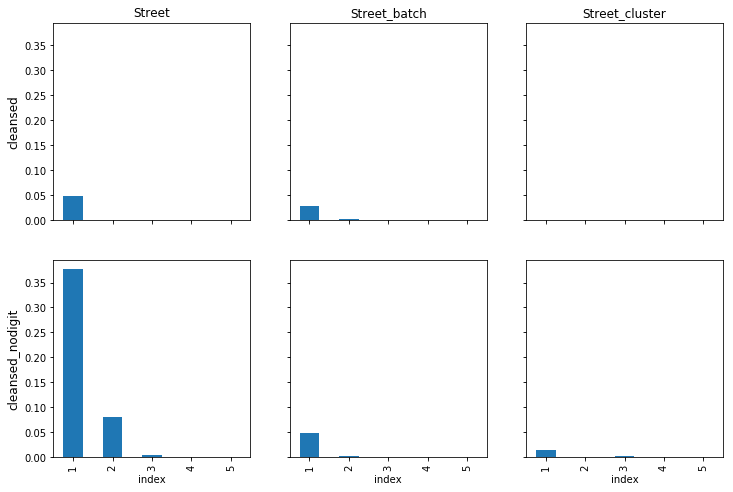

In [361]:
fig, axes = plt.subplots(len(cleansing_fields), len(names),  figsize=(12,4 * len(cleansing_fields)), sharey=True, sharex=True)

for i, field in enumerate(cleansing_fields):
    for j, col in enumerate(col_names):

        d = names[col][[field, "count", "count_box"]].reset_index()
        d = d.merge(d.rename(columns={"count": "count_2", "index": "index_2"}))
        d = d[(d["index"] != d["index_2"]) & (d["count"]<= d["count_2"])]
        if d.shape[0]>0:
            d = d[["index", "count_box"]].drop_duplicates()["count_box"].value_counts().sort_index().reset_index()
            d["rate"] = d.apply(lambda row: row["count_box"] / s[s["count_box"] == row["index"]]["count"].sum(), axis=1)

            #display(d)
            thrs = names[col][["count_box"]].drop_duplicates().sort_values("count_box").rename(columns={"count_box": "index"})[0:5]
            thrs.merge(d, how="left").fillna(0).set_index("index")["rate"].plot.bar(ax=axes[i,j])

    axes[i, 0].set_ylabel(field,  size='large')


for j, col in enumerate(col_names):
    axes[0, j].set_title(col)
    

# Inclusions

In [390]:
# cleansing_fields = ["orig", "cleansed", "cleansed_nodigit"]

compact_names  = {f: {} for f in cleansing_fields}

for field in cleansing_fields: 
    for col, n in names.items():
        compact_names[field][col] =  n[["count", field]].groupby(field)[["count"]].sum().sort_values(by="count", ascending=False).reset_index()#.rename(columns={"cleansed": "index"})
    
        compact_names[field][col]["count_box"]= find_box(compact_names[field][col]["count"])


In [373]:
inclusions = {f: {} for f in cleansing_fields}

for (field, col) in tqdm([(field, col) for col in compact_names[field] for field in compact_names]):
    inclusions[field][col] = get_inclusions(compact_names[field][col], field=field)

Proportions of values/records that contains a value with a higher or equal number of occurence. Inclusions are only considered if the difference in length between the two string in length is maximum 2 in relative value, and 10 in absolute value. For instance "A" is not considered as included in "AVENUE FONSNY", but "AVENUE FONSNY" is included in "AVENUE FONSNY, 20" of "20 AVENUE FONSNY".

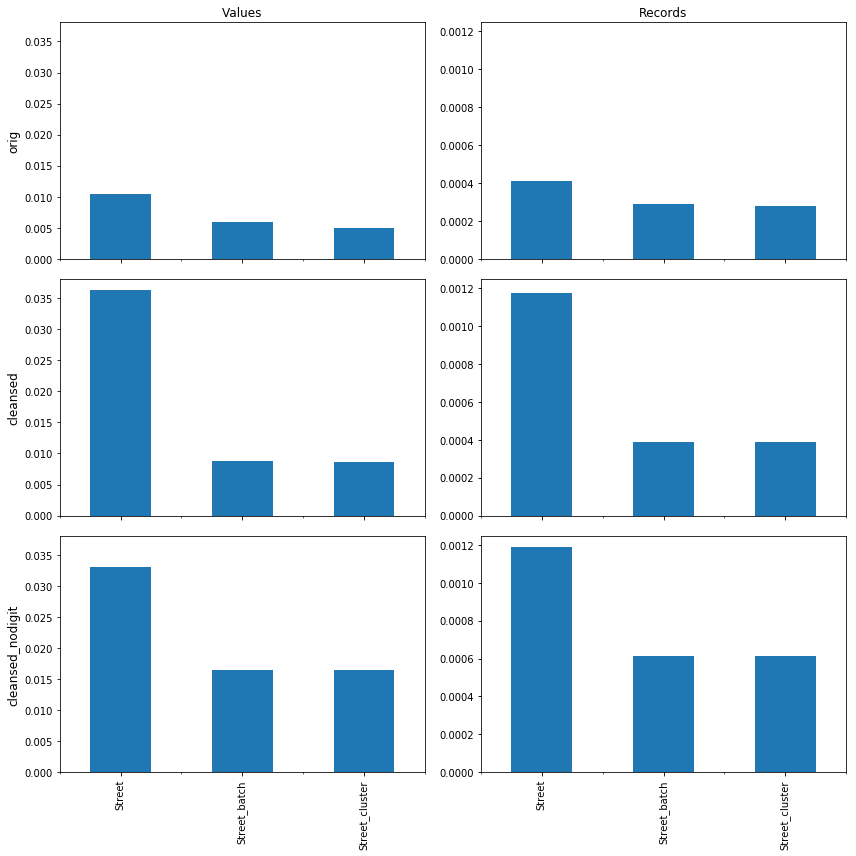

In [394]:
fig, axes = plt.subplots(len(cleansing_fields), 2,  figsize=(12,4 * len(cleansing_fields)), sharey="col", sharex=True)  #, sharex = True)

axes[0, 0].set_title("Values")
axes[0, 1].set_title("Records")

for i, f in enumerate(cleansing_fields): 
    pd.DataFrame(data= [incl.index_x.nunique() / compact_names[f][col].shape[0]  for col, incl in inclusions[f].items()], index = names.keys()).loc[col_names].plot.bar(ax=axes[i,0], legend=False)
    pd.DataFrame(data= [incl[["index_x", "count_x"]].drop_duplicates().count_x.sum() / compact_names[f][col]["count"].sum()  for col, incl in inclusions[f].items()], index = names.keys()).loc[ col_names].plot.bar(ax=axes[i, 1], legend=False)
    
    axes[i, 0].set_ylabel(f, size="large")
for i, field in enumerate(cleansing_fields):
    plt.setp(axes[i,1].get_yticklabels(),visible=True)

plt.tight_layout()

In [302]:
incl_rates = {}

for f in cleansing_fields:
    incl_rates[f] =  {col: {} for col in col_names}
    
    for col, incl in inclusions[f].items():

        s = compact_names[f][col]

        for thr in incl.count_box_x.unique():

            incl_rates[f][col][thr] = incl[(incl.count_box_x==thr)].count_x.sum() / s[s["count_box"] == thr]["count"].sum()


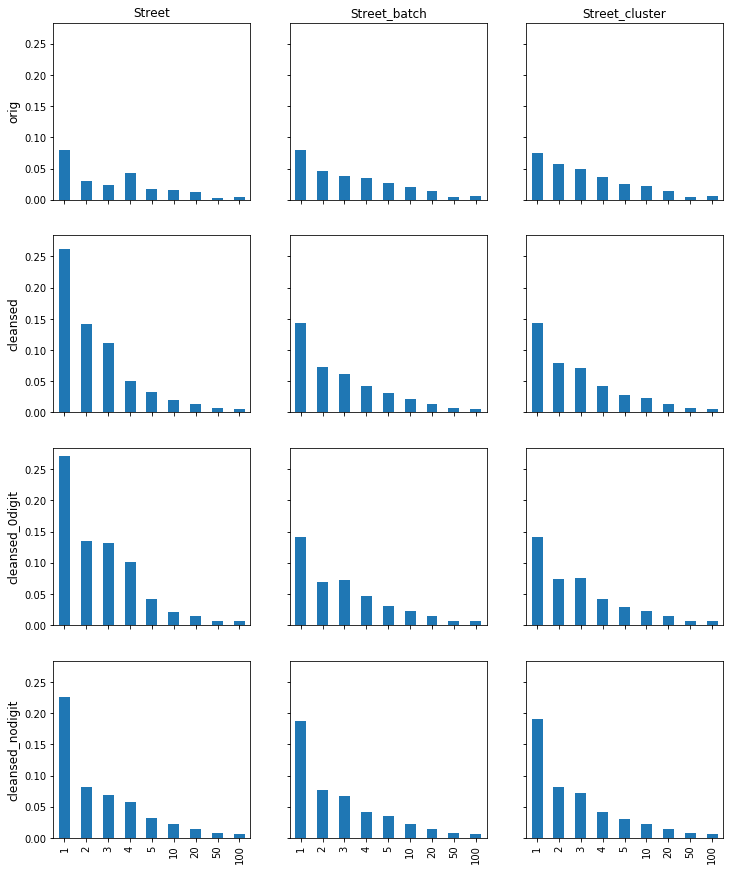

In [303]:
fig, axes = plt.subplots(len(cleansing_fields), len(names),  figsize=(12,15), sharey=True, sharex=True)

for i, field in enumerate(cleansing_fields):
    for j, col in enumerate(col_names):

        pd.DataFrame(incl_rates[field])[col].fillna(0).plot.bar(ax=axes[i,j])
        
    axes[i, 0].set_ylabel(field,  size='large')


for j, col in enumerate(col_names):
    axes[0, j].set_title(col)


# Similarity

In [386]:
# cleansing_fields = ["orig", "cleansed", "cleansed_nodigit"]

In [391]:
matches = {}

for f in cleansing_fields:
    print(f)
    matches[f] =  {}
    
    for col in col_names:
        print(col)
        matches[f][col] = get_matches(compact_names[f][col], 10, 0.9, field=f)

        display(matches[f][col].sort_values("similarity", ascending=False))

orig
Street
[11:33:58.074321] Vectorizing...
[11:33:58.453780] Run cossim...
[11:33:58.916689] Make match dataframe


left  left_count  left_count_box  left_idx  \
6296        CENTRE INTERNATIONAL ROGIE           1               1      5814   
915           rue Jean-Baptiste Colyns           1               1      4890   
249             Rue Théodore De Cuyper           1               1      6603   
161        rue de l'Hôtel des Monnaies           1               1      4963   
1528           rue Marguerite Bervoets           1               1      4868   
936       rue de l'Eglise Saint-Martin           1               1      4960   
3835                rue Docteur Kuborn           1               1      4846   
2383             rue Capitaine Joubert           1               1      4829   
1957                rue Joseph Cuylits           1               1      4897   
1744               rue Marie-Henriette           1               1      4869   
979                 rue Fernand Neuray           1               1      4802   
1051                 rue Jules Lejeune           1               1      4904   
180               rue des Deux Eglises           1               1      4970   
795                rue Alphonse Renard           2               2      4659   
396                    rue Middelbourg           1               1      4757   
2430                rue du Frontispice           1               1      5023   
1630                 rue Saint-Quentin           1               1      5081   
2099                  rue Baron Dhanis           1               1      5483   
292                    rue Dautzenberg           1               1      4840   
266                 rue de l'Autonomie           1               1      4958   
644                rue Vanderstichelen           2               2      4634   
2611                rue Cornet de Grez           1               1      4839   
525                  rue de Liedekerke           1               1      5108   
1939  rue Montagne aux Herbes Potagère           2               2      4608   
420                    rue Victor Hugo           1               1      5130   
2939                  rue Joseph Genot           1               1      4899   
2011             rue de la Grosse Tour           1               1      4913   
276                  rue Van Artevelde           1               1      5037   
880                rue des Hirondelles           1               1      5007   
597                    rue Traversière           1               1      5087   
...                                ...         ...             ...       ...   
3919                Clos des Orchidées           3               3      4097   
6081            6 A FRANKLIN ROOSEVELT           1               1      5121   
4774     Avenue de la Couronne 480-482           1               1      6602   
470                 Place du Châtelain         112             100       521   
3837            Drève du Rouge-Cloître           1               1      5711   
3957            Rue Théodore De Cuyper           1               1      6603   
146                   Place du Congrès          10              10      3334   
6550               rond Point Schumann           1               1      5475   
5654               50 A.DE L ARAUCARIA           1               1      5065   
2249             Square du Sacré-Coeur           8               5      3460   
5023        Station Metro Botaniques/n           1               1      5576   
4944                    1 GARE DU NORD           1               1      5621   
1534                     Rue Communale          25              20      2213   
799                  Clos des Fuchsias           2               2      4721   
7087                  AV.11 NOVEMBR.76           1               1      6543   
1526                   R de Moranville           1               1      6073   
1019            Square des Combattants          49              20      1368   
6907    Atomiumsquare B.I.T.M. Athenes           1               1      6385   
4417                   Rue des Arc

Street_batch
[11:34:19.406471] Vectorizing...
[11:34:19.699117] Run cossim...
[11:34:20.197216] Make match dataframe


left  left_count  left_count_box  left_idx  \
3814    PLACE DE LA MONNAIE-GALERIE DE           1               1      4871   
4246        CENTRE INTERNATIONAL ROGIE           1               1      5423   
1868  RUE MONTAGNE AUX HERBES POTAGÈRE           2               2      4425   
152                 CHAUSSÉE BRUXELLES           1               1      5454   
4631                RUE DE RIBEAUCOURT           1               1      5192   
107                     RUE RIBAUCOURT           2               2      4356   
71                     CHAUSSÉE HELMET           2               2      4460   
129                  AVENUE STALINGRAD           1               1      5723   
3991                      RUE L ABBAYE           1               1      5937   
3418   PLACE CHARLES ROGIER C.I.R. BUR           7               5      3587   
6206                  AVENUE DE WALZIN           1               1      4687   
127                    AVENUE MESSIDOR           1               1      5674   
4443                AVENUE DE COLOMBIE           1               1      4762   
4074                   AVENUE TERVUREN           1               1      5726   
1803           AVENUE GEORGES LECLERCQ          12              10      3074   
4800                        DE JONCKER           1               1      5575   
506             RUE DE LA CONSTITUTION          22              20      2388   
323                       RUE LINTHOUT           1               1      5700   
32                  RUE VANDERKINDEREN           1               1      5202   
5871               AVENUE E. BOCKSTAEL           1               1      4935   
1188          AVENUE DE LA HÉRONNIÈRES           1               1      4811   
666              RUE DU PONT DE LUTTRE           1               1      5588   
2011                    RUE LA STATION           1               1      5953   
899             AVENUE PRINCE BAUDOUIN          26              20      2188   
4924               ROND POINT SCHUMANN           1               1      4689   
4207                     AVENUE E BECO           2               2      4347   
831                     RUE NOTRE-DAME          18              10      2650   
5613   ATOMIUMSQUARE B.I.T.M. W. ACAPU           1               1      5277   
1254               RUE DE LA SAPINIÈRE          14              10      2949   
2111                  RUE LOUIS JASMIN          11              10      3235   
...                                ...         ...             ...       ...   
3767                CLOS DES ORCHIDÉES           3               3      4109   
747                  CLOS DES FUCHSIAS           2               2      4324   
978             SQUARE DES COMBATTANTS          49              20      1374   
1600                    RUE ANNEESSENS          37              20      1742   
431                    PLACE GAUCHERET          11              10      3183   
1614     RUE BOTANIQUE METRO BOTANIQUE           1               1      4756   
3858            DRÈVE DU ROUGE-CLOÎTRE           1               1      5618   
1879              PLACE DE LA DUCHESSE           1               1      5763   
1505                     RUE COMMUNALE          25              20      2245   
46                      PLACE DU TRÔNE           6               5      3782   
249                   Q DE L'INDUSTRIE           2               2      4613   
1110                  PLACE STEPHENSON           4               4      4087   
1004                 PLACE SAINT-JOSSE          44              20      1518   
1108                   RUE SCHEUTBOSCH           7               5      3668   
4866             RUE DES CHARBONNIERES           2               2      4546   
5376       ATOMIUMSQUARE B.I.T.M. BONN           1               1      5044   
4478      AVENUE DE L HOPITAL FRANCAIS           1               1      4742   
6114                  AVENUE LACOMBLEL           1               1      5741   
5983                      AVENUE D

Street_cluster
[11:34:38.640230] Vectorizing...
[11:34:38.920093] Run cossim...
[11:34:39.261731] Make match dataframe


left  left_count  left_count_box  left_idx  \
146                 CHAUSSÉE BRUXELLES           1               1      5539   
100                     RUE RIBAUCOURT           4               4      4057   
65                     CHAUSSÉE HELMET           2               2      4347   
124                  AVENUE STALINGRAD           1               1      5579   
5858                  AVENUE DE WALZIN           1               1      4841   
121                    AVENUE MESSIDOR           1               1      4775   
4322                AVENUE DE COLOMBIE           1               1      4906   
1402              RUE GÉNÉRAL LARTIGUE           1               1      5746   
1798           AVENUE GEORGES LECLERCQ          12              10      3070   
319                       RUE LINTHOUT           1               1      5595   
503             RUE DE LA CONSTITUTION          22              20      2416   
5465               AVENUE E. BOCKSTAEL           1               1      4985   
664              RUE DU PONT DE LUTTRE           1               1      5117   
1999                    RUE LA STATION           1               1      5481   
898             AVENUE PRINCE BAUDOUIN          26              20      2174   
17                   RUE CHARLES-QUINT          80              50       788   
4018                     AVENUE E BECO           2               2      4337   
1261                 RUE FÉLIX MARCHAL           1               1      5794   
821                     RUE NOTRE-DAME          18              10      2665   
1234               RUE DE LA SAPINIÈRE          14              10      2925   
401              RUE DE LA RENAISSANCE           1               1      5337   
80                     RUE PAUL HYMANS          32              20      1942   
1710                  RUE DE L'ESCRIME          35              20      1796   
2093                  RUE LOUIS JASMIN          11              10      3216   
5793                 AVENUE L LEPOUTRE           1               1      4765   
4230                 AVENUE DU MYSTÈRE           1               1      4958   
937               AVENUE DE LA RÉFORME          62              50      1057   
928                    RUE DES MIMOSAS          49              20      1371   
2650                RUE DES CAMPANULES           7               5      3554   
835                    RUE PAUL JANSON          16              10      2792   
...                                ...         ...             ...       ...   
39                          RUE ROGIER         163             100       304   
3829                CLOS DES ORCHIDÉES           3               3      4239   
741                  CLOS DES FUCHSIAS           2               2      4370   
148                   PLACE DU CONGRÈS          10              10      3304   
260                 RUE DE LA CAMBRE I           1               1      5342   
2547                      HOF TEN BERG          11              10      3181   
428                    PLACE GAUCHERET          11              10      3178   
1577                    RUE ANNEESSENS          37              20      1738   
3806            DRÈVE DU ROUGE-CLOÎTRE           1               1      5797   
1873              PLACE DE LA DUCHESSE           1               1      5399   
974             SQUARE DES COMBATTANTS          49              20      1355   
1491                     RUE COMMUNALE          25              20      2216   
1087                  PLACE STEPHENSON           4               4      3932   
44                      PLACE DU TRÔNE           6               5      3745   
5359       ATOMIUMSQUARE B.I.T.M. BONN           1               1      5075   
987                  PLACE SAINT-JOSSE          44              20      1512   
1101                   RUE SCHEUTBOSCH           7               5      3641   
4834              RUE DES CHARBONNIERS           2               2      4568   
238            CLOS THÉODORE DE CU

cleansed
Street
[11:34:52.836443] Vectorizing...
[11:34:53.136135] Run cossim...
[11:34:53.538896] Make match dataframe


left  left_count  left_count_box  left_idx  \
4253        CENTRE INTERNATIONAL ROGIE           1               1      6590   
1857  RUE MONTAGNE AUX HERBES POTAGERE           2               2      4580   
210    BOULEVARD DU JARDIN BOTANIQUE 1           3               3      4101   
3345    PLACE CHARLES ROGIER C I R BUR           8               5      3520   
3440   BOULEVARD EMILE JACQMAIN 162 WO           1               1      6331   
379                       RUE L ABBAYE           1               1      4799   
1792           AVENUE GEORGES LECLERCQ          12              10      3114   
6578                ROND POINT SCHUMAN           1               1      6253   
488             RUE DE LA CONSTITUTION          22              20      2400   
882             AVENUE PRINCE BAUDOUIN          26              20      2196   
4607   BOULEVARD EMILE JACQMAIN 162 B1           1               1      6330   
1179          AVENUE DE LA HERONNIERES           1               1      5303   
5606    ATOMIUMSQUARE B I T M W ACAPUL           1               1      5323   
1557                      RUE DE BRUYN           5               5      3839   
5609    ATOMIUMSQUARE B I T M W ACAPUL           1               1      5323   
4304    PLACE CHARLES ROGIER MANHATTAN           1               1      5897   
2639                RUE DES CAMPANULES           7               5      3601   
79                     RUE PAUL HYMANS          32              20      1937   
994        BD 2ME ARMEE BRITANNIQUE SN           1               1      6307   
913                    RUE DES MIMOSAS          49              20      1363   
1686                  RUE DE L ESCRIME          35              20      1823   
2088                  RUE LOUIS JASMIN          11              10      3226   
5180            TERHULPSESTEENWEG 130A           1               1      4918   
6705             AVENUE MOLIERE 489 12           1               1      6312   
814                    RUE PAUL JANSON          16              10      2775   
2538                 RUE DE LA PAILLES           1               1      6073   
530                  RUE DE BOETENDAEL          63              50      1046   
5640     ATOMIUMSQUARE B I T M AVIGNON           1               1      5357   
1228               RUE DE LA SAPINIERE          14              10      2958   
5580    AVENUE DE TERVUEREN STATION ME           1               1      5311   
...                                ...         ...             ...       ...   
953             SQUARE DES COMBATTANTS          49              20      1358   
4495    SQUARE DE L ATOMIUM B I T M AS           1               1      4867   
439           AVENUE DES SEPT BONNIERS          52              50      1290   
3547                SQUARE FRERE ORBAN           3               3      4118   
395               PLACE LEOPOLD WIENER          33              20      1875   
5130    SQUARE DE L ATOMIUM B I T M AT           1               1      4876   
6907               AVENUE FR ROOSEVELT           1               1      6401   
3842  PLACE DE LA MONNAIE GALERIE DE 2           1               1      6156   
2549                      HOF TEN BERG          11              10      3217   
6696   BOULEVARD ANSPACH 30 ANSPACH CE           1               1      6350   
74                          RUE ALBERT          25              20      2235   
328                PLACE SAINT LAMBERT          85              50       738   
2460                       STUYVENBERG          20              20      2487   
1465                     RUE COMMUNALE          25              20      2243   
3443   BOULEVARD EMILE JACQMAIN 162 B1           1               1      6330   
3827              PLACE DE LA QUERELLE           3               3      4080   
4282       BOULEVARD GENERAL WAHIS 16E           1               1      6601   
2342   PLACE CHARLES ROGIER C I R PLAC           1               1      5903   
2163              PLACE DU SACRE C

Street_batch
[11:35:11.006026] Vectorizing...
[11:35:11.291745] Run cossim...
[11:35:11.644322] Make match dataframe


left  left_count  left_count_box  left_idx  \
3819    PLACE DE LA MONNAIE GALERIE DE           1               1      5269   
4037        CENTRE INTERNATIONAL ROGIE           1               1      5658   
1866  RUE MONTAGNE AUX HERBES POTAGERE           2               2      4264   
2220               SQUARE LEOPOLDVILLE           1               1      4945   
4590                RUE DE RIBEAUCOURT           1               1      5428   
154                 CHAUSSEE BRUXELLES           1               1      5670   
109                     RUE RIBAUCOURT           2               2      4302   
889       RUE GEN DOSSIN DE ST GEORGES           1               1      5238   
73                     CHAUSSEE HELMET           2               2      4644   
131                  AVENUE STALINGRAD           1               1      4865   
5251      ATOMIUMSQUARE B I T M ATHENE           1               1      4924   
3400    PLACE CHARLES ROGIER C I R BUR           8               5      3515   
5397                     AVENUE WALZIN           1               1      4844   
129                    AVENUE MESSIDOR           1               1      4803   
3683   BOULEVARD EMILE JACQMAIN 162 WO           1               1      4790   
4358                AVENUE DE COLOMBIE           1               1      5079   
4156                   AVENUE TERVUREN           1               1      4866   
368                       RUE L ABBAYE           1               1      5856   
1401              RUE GENERAL LARTIGUE           1               1      5231   
1797           AVENUE GEORGES LECLERCQ          12              10      3127   
4921                        DE JONCKER           1               1      5587   
324                       RUE LINTHOUT           1               1      5610   
512             RUE DE LA CONSTITUTION          22              20      2410   
360                 AVENUE LLOYD GEORG           1               1      4703   
35                  RUE VANDERKINDEREN           1               1      5121   
450           AVENUE DE L INDEPENDANCE           1               1      5091   
2023                    RUE LA STATION           1               1      5849   
676              RUE DU PONT DE LUTTRE           1               1      5458   
912             AVENUE PRINCE BAUDOUIN          26              20      2200   
4628               ROND POINT SCHUMANN           1               1      5511   
...                                ...         ...             ...       ...   
3684   BOULEVARD EMILE JACQMAIN 162 AT           1               1      4788   
4438    SQUARE DE L ATOMIUM B I T M AS           1               1      5197   
1501                     RUE COMMUNALE          25              20      2242   
477                        RUE DOYENNE           1               1      5480   
1099                   RUE SCHEUTBOSCH           7               5      3653   
4089             CLOS D CINQUANTENAIRE           1               1      5228   
1890              PLACE DE LA DUCHESSE           1               1      5268   
327       AVENUE DES GLOIRE NATIONALES           1               1      5073   
1106                  PLACE STEPHENSON           4               4      3958   
331                BLOULEVARD POINCARE           1               1      4746   
435                    PLACE GAUCHERET          11              10      3155   
1155                  RUE SAINT PIERRE           8               5      3500   
1550                     RUE FONTAINAS          19              10      2596   
4439    SQUARE DE L ATOMIUM B I T M SH           1               1      5184   
252                   Q DE L INDUSTRIE           5               5      3896   
5010                 AVENUE LACOMBLELN           1               1      4687   
1595                    RUE ANNEESSENS          37              20      1753   
2473                       STUYVENBERG          20              20      2522   
1437              RUE DU PRES AUX 

Street_cluster
[11:35:26.868668] Vectorizing...
[11:35:27.130042] Run cossim...
[11:35:27.469216] Make match dataframe


left  left_count  left_count_box  left_idx  \
2170              SQUARE LEOPOLDVILLE           1               1      4967   
145                CHAUSSEE BRUXELLES           1               1      5584   
101                    RUE RIBAUCOURT           4               4      3917   
876      RUE GEN DOSSIN DE ST GEORGES           1               1      5218   
65                    CHAUSSEE HELMET           2               2      4489   
124                 AVENUE STALINGRAD           1               1      4653   
5301    ATOMIUMSQUARE B I T M ATHENES           1               1      4997   
5414                    AVENUE WALZIN           1               1      4667   
121                   AVENUE MESSIDOR           1               1      4698   
4407               AVENUE DE COLOMBIE           1               1      4952   
3629  BOULEVARD EMILE JACQMAIN 162 WO           1               1      4776   
364                      RUE L ABBAYE           1               1      5794   
1389             RUE GENERAL LARTIGUE           1               1      5224   
1795          AVENUE GEORGES LECLERCQ          12              10      3116   
317                      RUE LINTHOUT           1               1      5537   
502            RUE DE LA CONSTITUTION          22              20      2404   
2001                   RUE LA STATION           1               1      5750   
440          AVENUE DE L INDEPENDANCE           1               1      5126   
657             RUE DU PONT DE LUTTRE           1               1      5385   
892            AVENUE PRINCE BAUDOUIN          26              20      2194   
4110                    AVENUE E BECO           2               2      4385   
1254                RUE FELIX MARCHAL           1               1      5490   
5713               AVENUE E BOCKSTAEL           1               1      5060   
2120                 RUE LOUIS JASMIN          11              10      3221   
404             RUE DE LA RENAISSANCE           1               1      5466   
80                    RUE PAUL HYMANS          32              20      1915   
2662               RUE DES CAMPANULES           7               5      3540   
928                   RUE DES MIMOSAS          49              20      1349   
1715                 RUE DE L ESCRIME          35              20      1817   
5255   ATOMIUMSQUARE B I T M W ACAPUL           1               1      4959   
...                               ...         ...             ...       ...   
983            SQUARE DES COMBATTANTS          49              20      1351   
3619               SQUARE FRERE ORBAN           3               3      4228   
3630  BOULEVARD EMILE JACQMAIN 162 AT           1               1      4775   
4316   SQUARE DE L ATOMIUM B I T M AS           2               2      4286   
2192             PLACE DU SACRE COEUR           3               3      4088   
1488                    RUE COMMUNALE          25              20      2220   
469                       RUE DOYENNE           1               1      5398   
1861             PLACE DE LA DUCHESSE           1               1      5206   
1088                  RUE SCHEUTBOSCH           7               5      3554   
4021            CLOS D CINQUANTENAIRE           1               1      5633   
1094                 PLACE STEPHENSON           4               4      4030   
424                   PLACE GAUCHERET          11              10      3164   
1138                 RUE SAINT PIERRE           8               5      3526   
244                  Q DE L INDUSTRIE           5               5      3859   
4317   SQUARE DE L ATOMIUM B I T M SH           1               1      4890   
1536                    RUE FONTAINAS          19              10      2552   
2484                      STUYVENBERG          20              20      2516   
1608                   RUE ANNEESSENS          37              20      1748   
1414             RUE DU PRES AUX OIES           1               1      5387   
3   

cleansed_nodigit
Street
[11:35:44.150032] Vectorizing...
[11:35:44.329330] Run cossim...
[11:35:44.606337] Make match dataframe


left  left_count  left_count_box  left_idx  \
3975    PLACE DE LA MONNAIE GALERIE DE           1               1      5666   
4226        CENTRE INTERNATIONAL ROGIE           1               1      5769   
1947  RUE MONTAGNE AUX HERBES POTAGERE           2               2      4324   
4672                RUE DE RIBEAUCOURT           1               1      5288   
5800     ATOMIUMSQUARE B I T M ATHENES           1               1      5284   
3471    PLACE CHARLES ROGIER C I R BUR           8               5      3535   
4859            QUAI DES USINES MAGASI           1               1      5658   
425                       RUE L ABBAYE           1               1      5819   
5168                   AV OBSERVATOIRE           1               1      4719   
355                       RUE LINTHOUT           1               1      5779   
41                  RUE VANDERKINDEREN           1               1      5038   
2092                    RUE LA STATION           1               1      5814   
1863           AVENUE GEORGES LECLERCQ          12              10      3140   
631        RUE DE LA CROIX DE PIERRE A           1               1      4767   
3556       BOULEVARD EMILE JACQMAIN WO           1               1      5917   
6745               ROND POINT SCHUMANN           1               1      6031   
1996                 RUE DE L EVEQUE A           1               1      5020   
551             RUE DE LA CONSTITUTION          22              20      2380   
505            RUE DE L INDEPENDANCE B           1               1      4970   
170          BOULEVARD GENERAL WAHIS D           1               1      5920   
5127           RUE DE L INDEPENDANCE B           1               1      4970   
4323                          A E BECO           2               2      4569   
4432  BOULEVARD ANSPACH ANSPACH CENTER           1               1      5868   
506            RUE DE L INDEPENDANCE A           2               2      4711   
5721                      A DE JONCKER           1               1      5206   
955             AVENUE PRINCE BAUDOUIN          26              20      2187   
1245          AVENUE DE LA HERONNIERES           1               1      4859   
6606         BOULEVARD GENERAL WAHIS B           1               1      5919   
5245     ATOMIUMSQUARE B I T M W ACAPU           1               1      4795   
5249    ATOMIUMSQUARE B I T M W ACAPUL           1               1      4804   
...                                ...         ...             ...       ...   
5071                RUE VANDERKINDEREN           1               1      5038   
5877                       A LACOMBLEL           1               1      5343   
1557                     RUE COMMUNALE          25              20      2243   
5390                    BD DU REGENT A           1               1      4917   
4510    SQUARE DE L ATOMIUM B I T M SH           1               1      5322   
2578                       STUYVENBERG          20              20      2516   
6597        BOULEVARD EMILE JACQMAIN E           1               1      5848   
5852     SQUARE DE L ATOMIUM B I T M P           1               1      5323   
5161                      AV MOLIERE O           1               1      4731   
2587                    A ADRIEN BAYET           2               2      4551   
143                     RUE BELLIARD O           2               2      4691   
240        AVENUE DOCTEUR LEMOINE PARC           1               1      4951   
3620               A DE LA TOISON D OR           4               4      3985   
1166                   RUE SCHEUTBOSCH           7               5      3639   
6812                           A DEFRE           1               1      5072   
1544                      C DE LOUVAIN           8               5      3477   
2270              PLACE DU SACRE COEUR           3               3      4221   
2054    PLACE CHARLES ROGIER C I R E E           1               1      5751   
154                      A DES PAG

Street_batch
[11:35:58.210540] Vectorizing...
[11:35:58.402902] Run cossim...
[11:35:58.643477] Make match dataframe


left  left_count  left_count_box  left_idx  \
3962        CENTRE INTERNATIONAL ROGIE           1               1      5667   
3916    PLACE DE LA MONNAIE GALERIE DE           1               1      5251   
1896  RUE MONTAGNE AUX HERBES POTAGERE           2               2      4282   
2229               SQUARE LEOPOLDVILLE           1               1      4920   
4620                RUE DE RIBEAUCOURT           1               1      5406   
160                 CHAUSSEE BRUXELLES           1               1      5634   
112                     RUE RIBAUCOURT           2               2      4326   
911       RUE GEN DOSSIN DE ST GEORGES           1               1      5291   
76                     CHAUSSEE HELMET           2               2      4561   
137                  AVENUE STALINGRAD           1               1      4801   
5245      ATOMIUMSQUARE B I T M ATHENE           1               1      4888   
3447    PLACE CHARLES ROGIER C I R BUR           8               5      3474   
5416                     AVENUE WALZIN           1               1      4771   
134                    AVENUE MESSIDOR           1               1      4848   
4538                AVENUE DE COLOMBIE           1               1      5187   
4062                   AVENUE TERVUREN           1               1      4799   
4739            QUAI DES USINES MAGASI           1               1      5265   
382                       RUE L ABBAYE           1               1      5803   
1409              RUE GENERAL LARTIGUE           1               1      5284   
1842           AVENUE GEORGES LECLERCQ          12              10      3080   
4972                        DE JONCKER           1               1      5579   
334                       RUE LINTHOUT           1               1      5623   
522             RUE DE LA CONSTITUTION          22              20      2389   
374                 AVENUE LLOYD GEORG           1               1      4835   
37                  RUE VANDERKINDEREN           1               1      5095   
2063                    RUE LA STATION           1               1      5798   
464           AVENUE DE L INDEPENDANCE           1               1      5076   
690              RUE DU PONT DE LUTTRE           1               1      5439   
914             AVENUE PRINCE BAUDOUIN          26              20      2190   
3696       BOULEVARD EMILE JACQMAIN WO           1               1      4756   
...                                ...         ...             ...       ...   
1123                   RUE SCHEUTBOSCH           7               5      3636   
4163             CLOS D CINQUANTENAIRE           1               1      5679   
1885              PLACE DE LA DUCHESSE           1               1      5249   
4279                     AVENUE PLASKY           2               2      4373   
1117                  PLACE STEPHENSON           4               4      4067   
5364                    WERKHUIZENKAAI           1               1      4983   
1366      PLACE PRINCESSE ELISABETH AN           1               1      5283   
446                    PLACE GAUCHERET          11              10      3180   
343                BLOULEVARD POINCARE           1               1      4859   
1167                  RUE SAINT PIERRE           8               5      3469   
220        AVENUE DOCTEUR LEMOINE PARC           1               1      5119   
261                   Q DE L INDUSTRIE           5               5      3792   
1449              RUE DU PRES AUX OIES           1               1      5441   
1542                     RUE FONTAINAS          19              10      2585   
4534    SQUARE DE L ATOMIUM B I T M SH           1               1      5198   
1640                    RUE ANNEESSENS          37              20      1747   
5071                  AVENUE LACOMBLEL           1               1      4677   
2524                       STUYVENBERG          20              20      2531   
1000        AVENUE CHAPELLE AUX CH

Street_cluster
[11:36:13.314416] Vectorizing...
[11:36:13.458027] Run cossim...
[11:36:13.727305] Make match dataframe


left  left_count  left_count_box  left_idx  \
2202               SQUARE LEOPOLDVILLE           1               1      4970   
153                 CHAUSSEE BRUXELLES           1               1      5586   
105                     RUE RIBAUCOURT           4               4      3980   
893       RUE GEN DOSSIN DE ST GEORGES           1               1      5182   
69                     CHAUSSEE HELMET           2               2      4476   
131                  AVENUE STALINGRAD           1               1      4719   
5227      ATOMIUMSQUARE B I T M ATHENE           1               1      4898   
5439                     AVENUE WALZIN           1               1      4644   
128                    AVENUE MESSIDOR           1               1      4668   
4425                AVENUE DE COLOMBIE           1               1      4943   
4687            QUAI DES USINES MAGASI           1               1      5220   
374                       RUE L ABBAYE           1               1      5769   
1423              RUE GENERAL LARTIGUE           1               1      5218   
1816           AVENUE GEORGES LECLERCQ          12              10      3109   
331                       RUE LINTHOUT           1               1      5631   
515             RUE DE LA CONSTITUTION          22              20      2419   
2034                    RUE LA STATION           1               1      5782   
453           AVENUE DE L INDEPENDANCE           1               1      4932   
673              RUE DU PONT DE LUTTRE           1               1      5378   
913             AVENUE PRINCE BAUDOUIN          26              20      2172   
3644       BOULEVARD EMILE JACQMAIN WO           1               1      4811   
4182  BOULEVARD ANSPACH ANSPACH CENTER           1               1      4817   
4036                     AVENUE E BECO           2               2      4384   
1267                 RUE FELIX MARCHAL           1               1      5451   
2137                  RUE LOUIS JASMIN          11              10      3189   
5762                AVENUE E BOCKSTAEL           1               1      5045   
414              RUE DE LA RENAISSANCE           1               1      5439   
85                     RUE PAUL HYMANS          32              20      1942   
2714                RUE DES CAMPANULES           7               5      3580   
933                    RUE DES MIMOSAS          49              20      1360   
...                                ...         ...             ...       ...   
2185              PLACE DU SACRE COEUR           3               3      4112   
3646       BOULEVARD EMILE JACQMAIN AT           1               1      4858   
480                        RUE DOYENNE           1               1      5359   
1101                   RUE SCHEUTBOSCH           7               5      3540   
1878              PLACE DE LA DUCHESSE           1               1      5184   
4132             CLOS D CINQUANTENAIRE           1               1      5622   
4238                     AVENUE PLASKY           2               2      4554   
1114                  PLACE STEPHENSON           4               4      3982   
1361      PLACE PRINCESSE ELISABETH AN           1               1      5202   
440                    PLACE GAUCHERET          11              10      3193   
213        AVENUE DOCTEUR LEMOINE PARC           1               1      5144   
5081                WERKHUIZENKAAI MAG           1               1      4766   
1145                  RUE SAINT PIERRE           8               5      3452   
254                   Q DE L INDUSTRIE           5               5      3833   
4419    SQUARE DE L ATOMIUM B I T M SH           1               1      4892   
1454              RUE DU PRES AUX OIES           1               1      5362   
1535                     RUE FONTAINAS          19              10      2551   
2525                       STUYVENBERG          20              20      2484   
1619                    RUE ANNEES

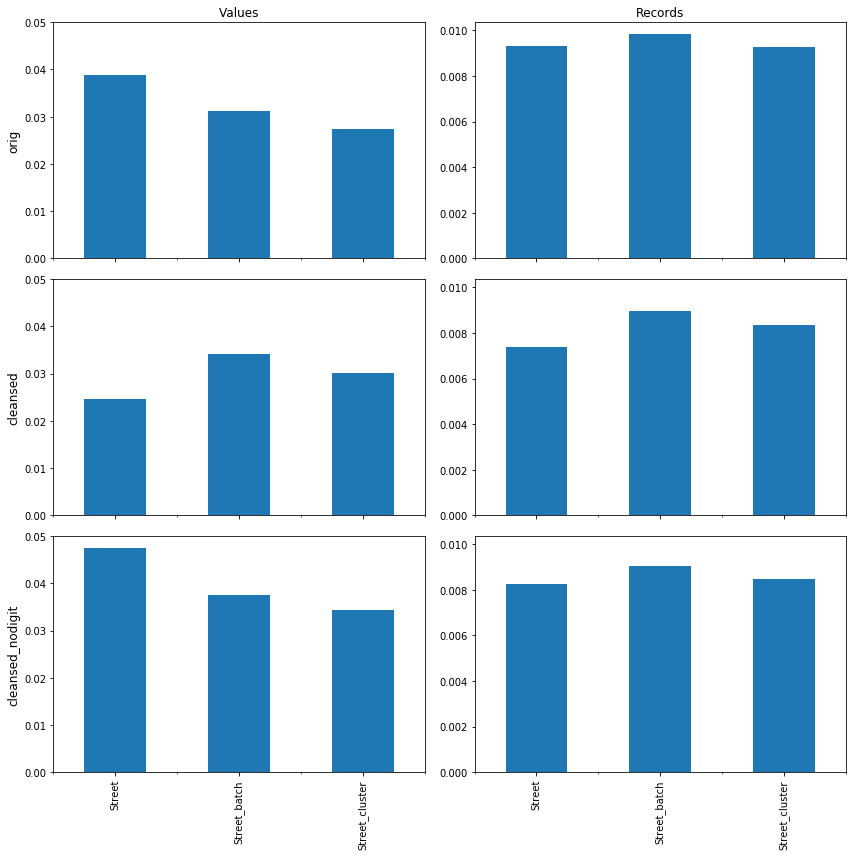

In [392]:
# Proportion of values being similar to another one

fig, axes = plt.subplots(len(cleansing_fields), 2,  figsize=(12,4 * len(cleansing_fields)), sharey="col", sharex=True)  #, sharex = True)

    
axes[0, 0].set_title("Values")
axes[0, 1].set_title("Records")

for i, f in enumerate(cleansing_fields):
    pd.DataFrame(data= [mtch.left_idx.nunique() / compact_names[f][col].shape[0]  for col, mtch in matches[f].items()], index = names.keys()).loc[col_names].plot.bar(ax=axes[i, 0], legend=False)
    pd.DataFrame(data= [mtch[["left_idx", "left_count"]].drop_duplicates().left_count.sum() / compact_names[f][col]["count"].sum()  for col, mtch in matches[f].items()], index = names.keys()).loc[col_names].plot.bar(ax=axes[i, 1], legend=False)
    
    axes[i, 0].set_ylabel(f, size="large")
   

for i, field in enumerate(cleansing_fields):
    plt.setp(axes[i,1].get_yticklabels(),visible=True)

plt.tight_layout()


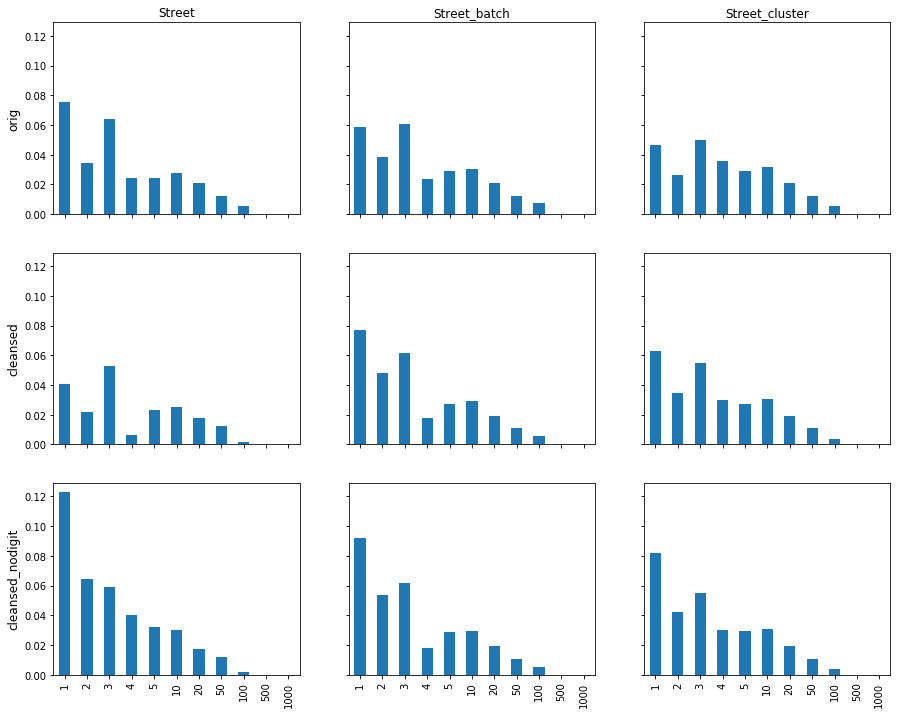

In [393]:
fig, axes = plt.subplots(len(cleansing_fields), len(col_names),  figsize=(15,12), sharex = True, sharey=True)

for i, f in enumerate(cleansing_fields):

    for j, col in enumerate(col_names):
        #print(i, col)

        n = compact_names[f][col]
        m = matches[f][col]

        thrs = n.count_box.unique() #range(1,50)

        stats = pd.DataFrame(columns = ["thr"], data = pd.Series(thrs))
        stats = stats.merge(n.groupby("count_box").apply(len).rename("nb_val"),          left_on="thr",right_index=True, how="left")

        stats = stats.merge(m[["left", "left_count", "left_count_box", "left_idx"]].drop_duplicates().groupby("left_count_box").left_idx.count().rename("nb_val_sim"), left_on="thr",right_index=True, how="left")

        stats["sim_val_ratio"] = stats["nb_val_sim"]/stats["nb_val"]

        m_sup = m[m.right_count >= m.left_count]

        stats = stats.merge(m_sup[["left", "left_count", "left_count_box", "left_idx"]].drop_duplicates().groupby("left_count_box").left_idx.count().rename("nb_val_sim_sup"), left_on="thr",right_index=True, how="left")

        stats["sim_val_ratio_sup"] = stats["nb_val_sim_sup"]/stats["nb_val"]

        stats.set_index("thr").sort_index().sim_val_ratio_sup.rename(f).fillna(0).plot.bar(ax = axes[i, j], legend=False)

    
    
    axes[i, 0].set_ylabel(f,  size='large')

for j, col in enumerate(col_names):
    axes[0, j].set_title(col)
    axes[-1, j].set_xlabel("")